<a href="https://colab.research.google.com/github/clphan/k8s-resource-recommendations-system/blob/master/bi_lstm_validate_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from joblib import load
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib.pyplot as plt
from joblib import dump, load
from pandas.plotting import lag_plot, autocorrelation_plot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# Load the model weights from an HDF5 file
model = load_model('/content/drive/MyDrive/thesis/model-out/bi-lstm-model.h5')
scaler_eventcount = load('/content/drive/MyDrive/thesis/model-out/scaler-eventcount-bi-lstm.joblib')
scaler = load('/content/drive/MyDrive/thesis/model-out/scaler-bi-lstm.joblib')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/processed-data/wc_dataset_processed_noise_removed.csv')
df.head()

,event_time,event_count,sum_bytes,num_match_event
0,1998-04-30 21:30:00,1,24736,0
1,1998-04-30 21:31:00,11,83086,0
2,1998-04-30 21:32:00,16,87949,0
3,1998-04-30 21:33:00,7,149401,0
4,1998-04-30 21:34:00,3,50457,0


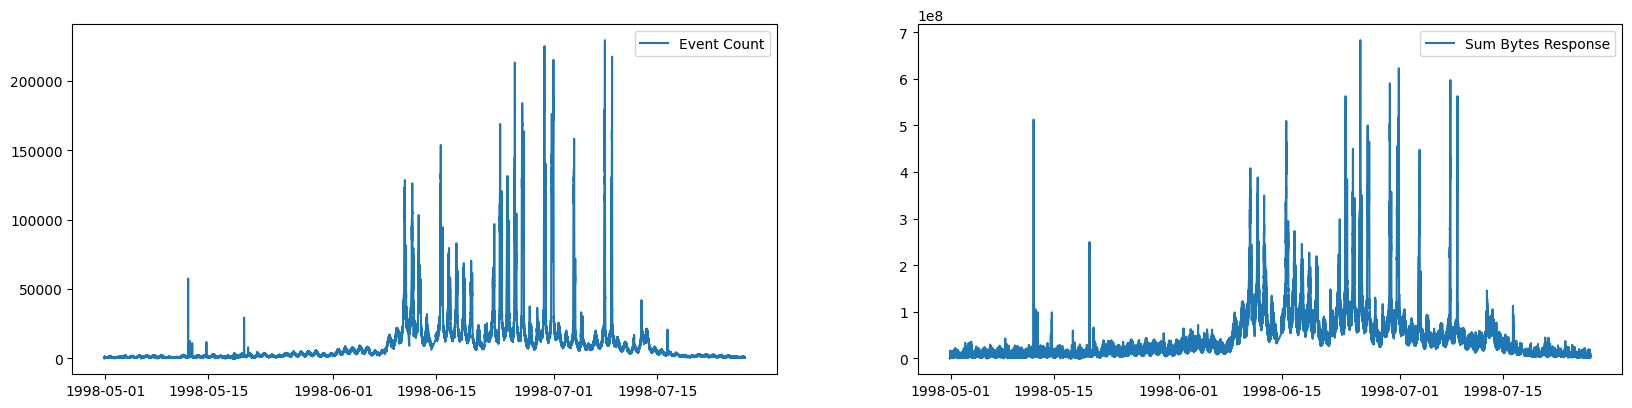

In [ ]:
df_plot_noise = df
df_plot_noise['event_time'] = pd.to_datetime(df_plot_noise['event_time'])
# Show the plot event_count
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 2, 1)  # Top left
ax2 = fig.add_subplot(2, 2, 2)  # Top right

ax1.plot(color='red', marker='o', markerfacecolor='blue')
ax1.plot(df_plot_noise['event_time'], df_plot_noise['event_count'], label='Event Count')#, color='blue')
# ax1.set_title('Event Count vs Time')
ax1.legend()
# Show the plot num_bytes_response
ax2.plot(color='red', marker='o', markerfacecolor='orange')
ax2.plot(df_plot_noise['event_time'], df_plot_noise['sum_bytes'], label='Sum Bytes Response')#,  color='green')
# ax2.set_title('Sum Bytes Response vs Time')
ax2.legend()

plt.show()

In [ ]:
# Step 3: Prepare the input and output data
# Create a function to create input and output data for the LSTM model
def create_input_output_data(scaled_data, sequence_length):
    X, Y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        Y.append(scaled_data.iloc[i + sequence_length])
    return np.array(X), np.array(Y)

In [ ]:
# Define the sequence length for the LSTM model
sequence_length = 10
# Create input and output data for the LSTM model
df_input = df[['event_count', 'sum_bytes', 'num_match_event']]
df_input[['sum_bytes', 'num_match_event']] = scaler.transform(df_input[['sum_bytes', 'num_match_event']])
df_input[['event_count']] = scaler_eventcount.transform(df_input[['event_count']])
X, Y = create_input_output_data(df_input, sequence_length)

<ipython-input-35-b03c71eb20b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[['sum_bytes', 'num_match_event']] = scaler.transform(df_input[['sum_bytes', 'num_match_event']])
<ipython-input-35-b03c71eb20b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[['event_count']] = scaler_eventcount.transform(df_input[['event_count']])


In [ ]:
df_input

,event_count,sum_bytes,num_match_event
0,0.000004,0.000036,0.0
1,0.000048,0.000122,0.0
2,0.000070,0.000129,0.0
3,0.000031,0.000219,0.0
4,0.000013,0.000074,0.0
...,...,...,...
123648,0.003387,0.003836,0.0
123649,0.003330,0.004113,0.0
123650,0.003578,0.007083,0.0
123651,0.002384,0.005548,0.0


In [ ]:
df.shape, X.shape, Y.shape

((123653, 4), (123643, 10, 3), (123643, 3))

In [ ]:
X[0], Y[0], X[1], Y[1], X[-2], Y[-2], X[-1], Y[-1]

(array([[4.35870390e-06, 3.62097597e-05, 0.00000000e+00],
        [4.79457429e-05, 1.21625327e-04, 0.00000000e+00],
        [6.97392623e-05, 1.28744023e-04, 0.00000000e+00],
        [3.05109273e-05, 2.18700449e-04, 0.00000000e+00],
        [1.30761117e-05, 7.38614103e-05, 0.00000000e+00],
        [8.71740779e-06, 7.24195194e-05, 0.00000000e+00],
        [1.30761117e-05, 1.08629279e-04, 0.00000000e+00],
        [1.74348156e-05, 1.44839039e-04, 0.00000000e+00],
        [2.17935195e-05, 1.46280930e-04, 0.00000000e+00],
        [3.92283351e-05, 2.55188340e-04, 0.00000000e+00]]),
 array([4.35870390e-06, 3.62097597e-05, 0.00000000e+00]),
 array([[4.79457429e-05, 1.21625327e-04, 0.00000000e+00],
        [6.97392623e-05, 1.28744023e-04, 0.00000000e+00],
        [3.05109273e-05, 2.18700449e-04, 0.00000000e+00],
        [1.30761117e-05, 7.38614103e-05, 0.00000000e+00],
        [8.71740779e-06, 7.24195194e-05, 0.00000000e+00],
        [1.30761117e-05, 1.08629279e-04, 0.00000000e+00],
        [1.7

In [ ]:
df[-1:]

,event_time,event_count,sum_bytes,num_match_event
123652,1998-07-26 21:59:00,679,4651819,0


In [ ]:
# Step 4: Split the data into training, validation and test sets
# Define the training, validation and testing set sizes
training_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.85)

# Split the data into training and testing sets
X_train, X_validation, X_test = X[:training_size], X[training_size:validation_size], X[validation_size:]
Y_train, Y_validation, Y_test = Y[:training_size], Y[training_size:validation_size], Y[validation_size:]

In [ ]:
Y_train = Y_train[:,0].reshape(-1,1)
Y_validation = Y_validation[:,0].reshape(-1,1)
Y_test = Y_test[:,0].reshape(-1,1)

In [ ]:
X_train.shape, X_validation.shape, X_test.shape

((86550, 10, 3), (18546, 10, 3), (18547, 10, 3))

In [ ]:
Y_train.shape, Y_validation.shape, Y_test.shape

((86550, 1), (18546, 1), (18547, 1))

In [ ]:
predict_validation = model.predict(X_validation)

580/580 [==============================] - 15s 26ms/step


In [ ]:
predict_test = model.predict(X_test)

580/580 [==============================] - 15s 26ms/step


In [ ]:
Y_validation

array([[0.70643258],
       [0.70516419],
       [0.71637914],
       ...,
       [0.0675294 ],
       [0.06570746],
       [0.0620941 ]])

In [ ]:
predict_validation_inverse = scaler_eventcount.inverse_transform(predict_validation)
real_validation_inverse = scaler_eventcount.inverse_transform(Y_validation)

In [ ]:
predict_test_inverse = scaler_eventcount.inverse_transform(predict_test)
real_test_inverse = scaler_eventcount.inverse_transform(Y_test)

In [ ]:
predict_validation_inverse.shape, predict_test_inverse.shape

((18546, 1), (18547, 1))

In [ ]:
plot_validation = real_validation_inverse
plot_validation = pd.DataFrame(plot_validation)
plot_validation.columns = ['real_validation']
plot_validation.head()
plot_validation['predict_validation'] = predict_validation_inverse
plot_validation.head()
# plot_validation.columns = ['real_validation', 'predict_validation']

,real_validation,predict_validation
0,162074.0,158387.328125
1,161783.0,162795.968750
2,164356.0,163368.234375
3,165928.0,165183.234375
4,165907.0,167102.968750


In [ ]:
plot_test = real_test_inverse
plot_test = pd.DataFrame(plot_test)
plot_test.columns = ['real_test']
plot_test['predict_test'] = predict_test_inverse
plot_test.columns = ['real_test', 'predict_test']
plot_test.head()

,real_test,predict_test
0,14688.0,14671.451172
1,14914.0,14873.881836
2,15516.0,15006.618164
3,14392.0,15366.103516
4,15417.0,14727.772461


<Axes: >

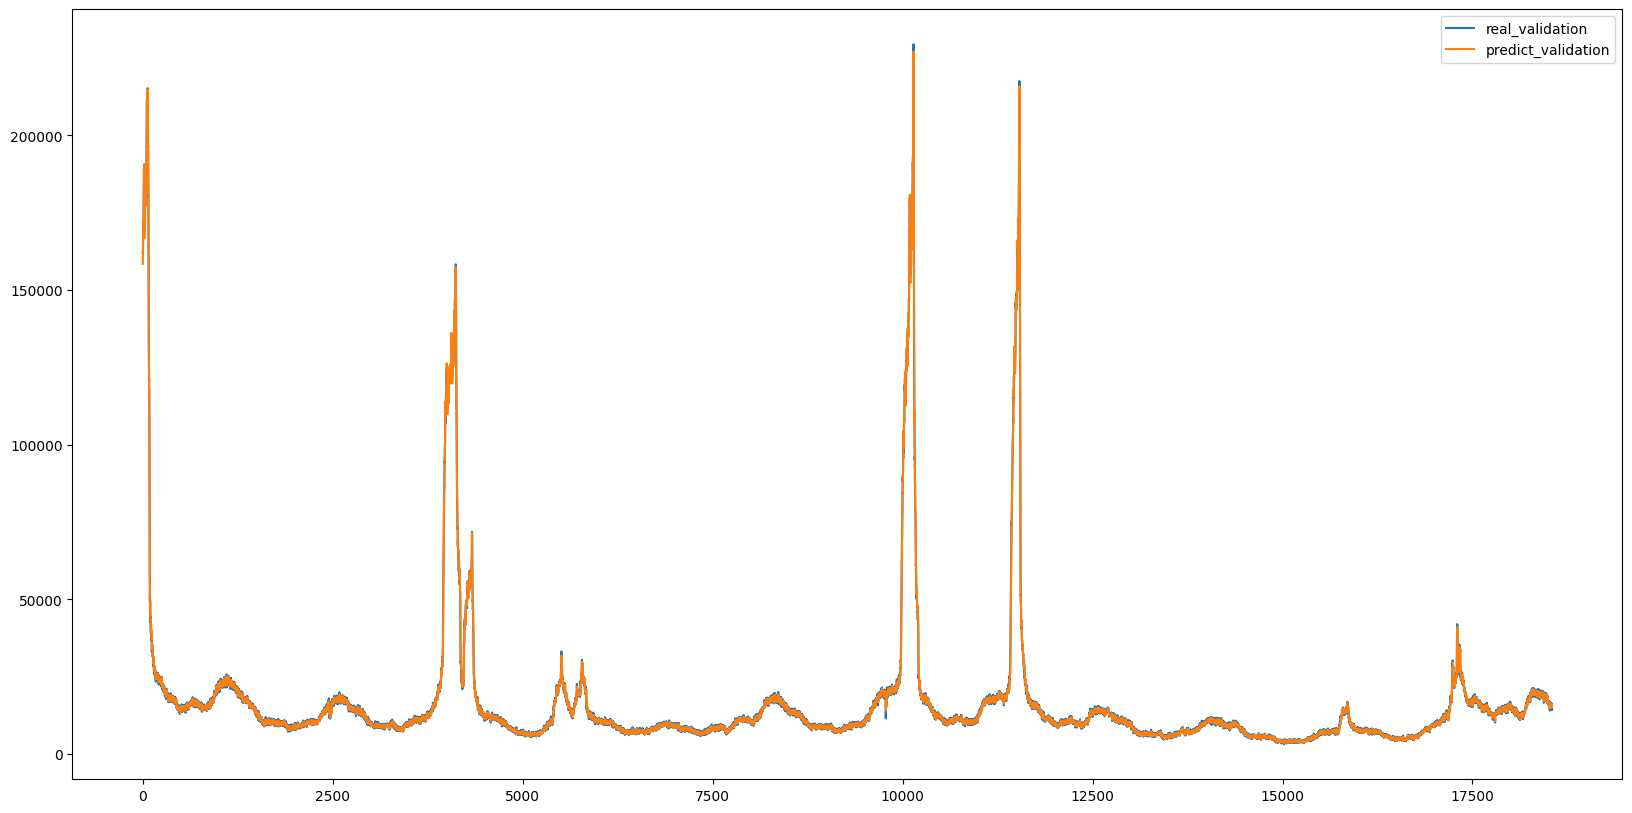

In [ ]:
plot_validation.plot(figsize=(20,10))

<Axes: >

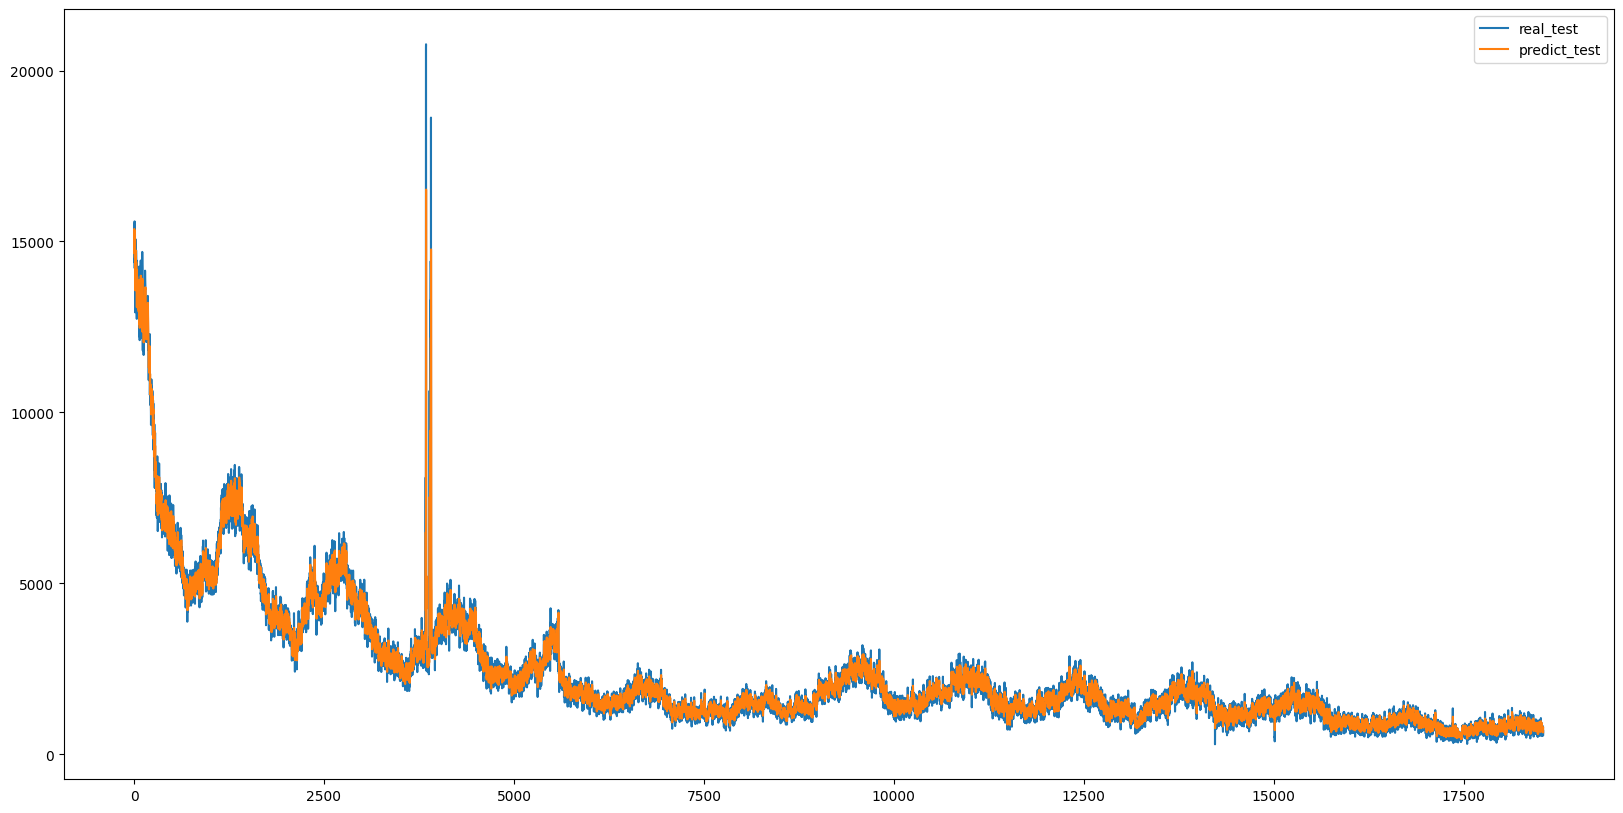

In [ ]:
plot_test.plot(figsize=(20,10))

**Validate error between predict and read data (tap validate)**

In [ ]:
predict_validate = predict_validation_inverse
real_validate = real_validation_inverse

In [ ]:
squared_errors = (real_validate - predict_validate) ** 2
mse = np.mean(squared_errors)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 927.1393295235134


In [ ]:
# Calculate the absolute differences between the actual and predicted values
absolute_errors = np.abs(real_validate - predict_validate)

# Calculate the mean absolute error (MAE)
mae = np.mean(absolute_errors)

print("MAE:", mae)

MAE: 523.7454203952545


Validate error between predict and read data (tap test)

In [ ]:
predict_test = predict_test_inverse
real_test = real_test_inverse

In [ ]:
squared_errors = (real_test - predict_test) ** 2
mse = np.mean(squared_errors)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 333.52245938502875


In [ ]:
# Calculate the absolute differences between the actual and predicted values
absolute_errors = np.abs(real_test - predict_test)

# Calculate the mean absolute error (MAE)
mae = np.mean(absolute_errors)

print("MAE:", mae)

MAE: 174.1378159825613


**Validate system**

In [ ]:
# Dataset
# Data
data = [
    ['1998-06-15 19:31:00', '1998-06-15 19:55:00', '<5%', '7', '6', '2'],
    ['1998-06-16 10:58:00', '1998-06-16 11:26:00', '<5%', '4', '4', '1'],
    ['1998-06-16 12:44:00', '1998-06-16 13:08:00', '< 5%', '2', '1', '1'],
    ['1998-07-07 15:36:00', '1998-07-07 15:58:00', '< 5%', '2', '3', '1'],
    ['1998-07-07 18:40:00', '1998-07-07 19:03:00', '<5%', '4', '3', '2'],
    ['1998-07-07 18:59:00', '1998-07-07 19:18:00', '<5%', '1', '1', '1'],
    ['1998-07-08 18:17:00', '1998-07-08 18:32:00', '<5%', '10', '7', '1']
]

In [ ]:
# Extracting the relevant columns
row_numbers = range(1, len(data) + 1)
col_4 = [int(row[3]) for row in data]
col_5 = [int(row[4]) for row in data]
col_6 = [int(row[5]) for row in data]

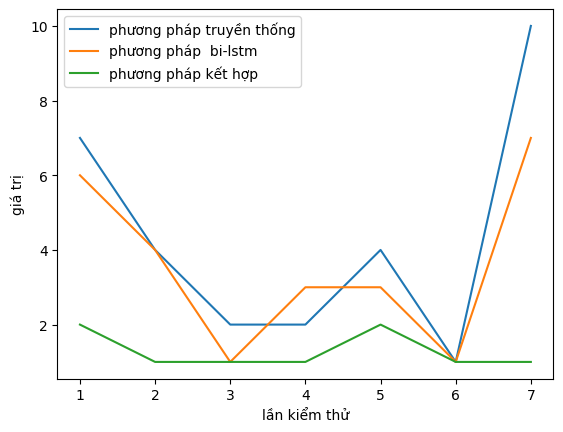

In [ ]:
# Plotting
plt.plot(row_numbers, col_4, label='phương pháp truyền thống')
plt.plot(row_numbers, col_5, label='phương pháp  bi-lstm')
plt.plot(row_numbers, col_6, label='phương pháp kết hợp')
plt.xlabel('lần kiểm thử')
plt.ylabel('giá trị')
plt.legend()
plt.show()